# Multi-task Vision Transformer model

In [10]:
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras
from keras import ops
import pandas as pd
import numpy as np
import random

# Model configuration

In [11]:
# Dataset values
IMAGE_SIZE = 384

# Model configs
patch_size = 32
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
age_k = 3

# Transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4

# MLP units
mlp_head_units = [2048, 1024, 512, 64, 32]


# FaceVit losses and metrics
facevit_losses = {
    "face": keras.losses.MeanSquaredError(),
    "gender": keras.losses.BinaryCrossentropy(),
    "age": keras.losses.CategoricalFocalCrossentropy()
}

facevit_metrics = {
    "face": 'mse',
    "gender": 'accuracy',
    "age": tf.keras.metrics.TopKCategoricalAccuracy(k=age_k, name=f'top_{age_k}_accuracy', dtype=None)
}

def model_compiler(model, optimizer, loss, metrics):
    "Model compilation function"
    model.compile(optimizer= optimizer, loss= loss, metrics = metrics)
    return model

In [3]:
# Dataset values
IMAGE_SIZE = 384

# Model configs
patch_size = 32
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
age_k = 3

# Transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4

# MLP units
mlp_head_units = [2048, 1024, 512, 64, 32]


# FaceVit losses and metrics
facevit_losses = {
    "face": keras.losses.MeanSquaredError(),
    "gender": keras.losses.BinaryCrossentropy(),
    "age": keras.losses.CategoricalFocalCrossentropy()
}

facevit_metrics = {
    "face": 'mse',
    "gender": 'accuracy',
    "age": tf.keras.metrics.TopKCategoricalAccuracy(k=age_k, name=f'top_{age_k}_accuracy', dtype=None)
}

def model_compiler(model, optimizer, loss, metrics):
    "Model compilation function"
    model.compile(optimizer= optimizer, loss= loss, metrics = metrics)
    return model

# Load and prepare dataset

### Pre-processing

In [12]:
def create_age_bins_and_encode(df,
                               bin_size=5,
                               max_age = 100,
                               json_output_path='age/age_bins.json',
                               write_json = True):
    """
    Function to bin ages into configurable intervals, encode the bins, and save the encoding dictionary in JSON format.

    Parameters:
    df (pd.DataFrame): DataFrame containing the age column.
    bin_size (int): Size of each age bin (default is 5 years).
    json_output_path (str): Path to save the JSON dictionary mapping age bins to encoded labels.

    Returns:
    pd.DataFrame: DataFrame with an additional column for encoded age bins.
    """
    import json
    from sklearn.preprocessing import LabelEncoder

    # Define the age bins and bin labels
    bins = range(0, max_age, bin_size)
    labels = [f'{i}-{i + bin_size - 1}' for i in range(0, max_age- bin_size, bin_size)]

    # Bin the ages
    df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

    # Encode the age bins into class indexes
    label_encoder = LabelEncoder()
    df['age_class'] = label_encoder.fit_transform(df['age_bin'])
    age_bin_mapping = dict(zip(df['age_bin'], df['age_class']))

    # Save the dictionary as a JSON file
    if write_json:
        with open(json_output_path, 'w') as json_file:
            json.dump(age_bin_mapping, json_file)

    return df, len(age_bin_mapping)

### Augmentations pipeline

In [14]:
def apply_color_augmentation(image):
    augmentations = [
        lambda img: tf.image.random_brightness(img, max_delta=0.2),
        lambda img: tf.image.random_contrast(img, lower=0.5, upper=1.5),
        lambda img: tf.image.random_saturation(img, lower=0.5, upper=1.5),
        lambda img: tf.image.random_hue(img, max_delta=0.2)
    ]

    # Randomly select 2 augmentations to apply
    chosen_augmentations = random.sample(augmentations, 2)

    for aug in chosen_augmentations:
        image = aug(image)

    # Ensure values remain within 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

def apply_augmentations_fn(images, ground_truth):
    """Only color based augmentatios are used for simplicity"""
    # Apply some simple color augmentations to the images
    augmented_images = tf.map_fn(apply_color_augmentation, images)
    return augmented_images, ground_truth

### Dataset builder

In [15]:
def create_tf_dataset(csv_file, images_dir, batch_size, target_size=(384, 384), augment=False, write_json = True):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Convert gender to 0 for male and 1 for female
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})

    # Extract relevant columns (age, gender, and face bounding box)
    df = df[['img_name','age', 'gender', 'face_x0', 'face_y0', 'face_x1', 'face_y1']]

    # Create file paths for images
    df['img_path'] = images_dir + '/' + df['img_name']

    # Convert box to numeric
    df['face_x0'] = pd.to_numeric(df['face_x0'])
    df['face_y0'] = pd.to_numeric(df['face_y0'])
    df['face_x1'] = pd.to_numeric(df['face_x1'])
    df['face_y1'] = pd.to_numeric(df['face_y1'])

    # Create the age bin with bins per 5 years for classification task
    # Save the labels dictionary to a json file for decoding predictions
    df, num_age_groups = create_age_bins_and_encode(df, bin_size=5, write_json = write_json)

    def load_and_preprocess_image(img_path, age, gender, face_x0, face_y0, face_x1, face_y1, age_groups_n = num_age_groups):
        # Load image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)

        # Get original width and height before resizing to scale the boxes
        original_height = tf.cast(tf.shape(img)[0], dtype=tf.int64)
        original_width = tf.cast(tf.shape(img)[1], dtype=tf.int64)

        # Rescale/normalize bounding box coordinates
        face_x0_scaled = face_x0 / original_width
        face_y0_scaled = face_y0 / original_height
        face_x1_scaled = face_x1 / original_width
        face_y1_scaled = face_y1 / original_height

        # Resize and normalize
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0

        # Concatenate normalized coordinates
        bounding_box = tf.convert_to_tensor([face_x0_scaled, face_y0_scaled,
                                            face_x1_scaled, face_y1_scaled])

        # Convert gender and age to tensors
        gender_tensor = tf.cast(tf.convert_to_tensor(gender), dtype=tf.int32)
        age_tensor = tf.cast(tf.convert_to_tensor(age), dtype=tf.int32)
        age_tensor = tf.one_hot(age_tensor, depth=age_groups_n)

        # Return image and concatenated ground truth tensor
        return img, (bounding_box, gender_tensor, age_tensor)


    # Create TensorFlow dataset from DataFrame
    dataset = tf.data.Dataset.from_tensor_slices((
        df['img_path'].values,
        df['age_class'].values,
        df['gender'].values,
        df['face_x0'].values,
        df['face_y0'].values,
        df['face_x1'].values,
        df['face_y1'].values
    ))

    # Load and preprocess images in parallel
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(batch_size, drop_remainder= True)

    if augment:
        dataset = dataset.map(apply_augmentations_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset, num_age_groups

def plot_image_with_boxes(image, bbox, image_size = (384,384,3)):
    """Helper plotting function"""
    # Create figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)
    h, w, _ = image_size

    bbox = [coord for coord in bbox]

    x1, y1, x2, y2 = bbox

    # Scale and calculate width and height
    x1 = x1 * w
    y1 = y1 * h
    x2 = x2 * w
    y2 = y2 * h
    width = x2 - x1
    height = y2 - y1

    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the plot
    ax.add_patch(rect)

    # Show plot
    plt.show()

# Splits

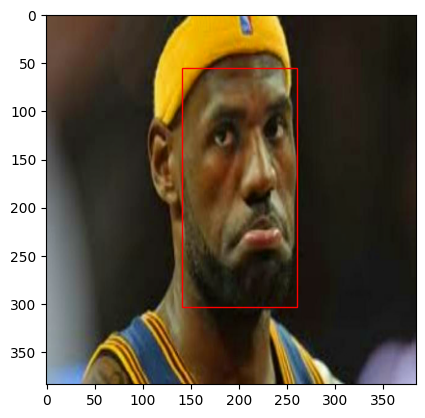

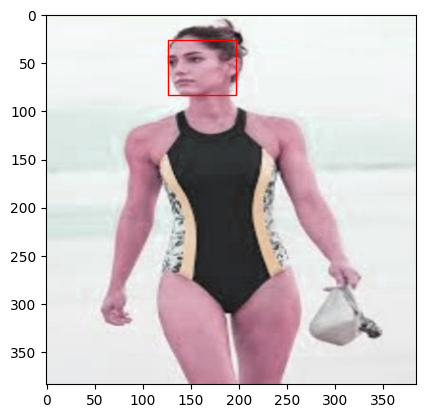

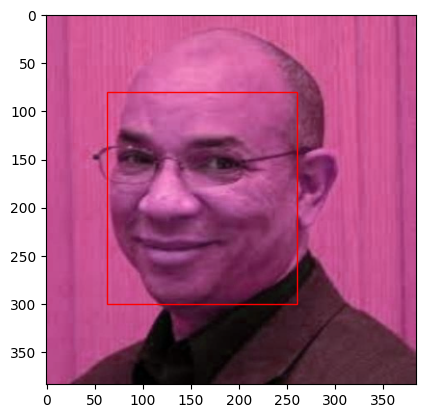

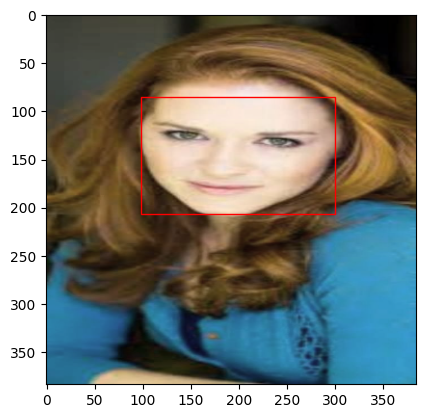

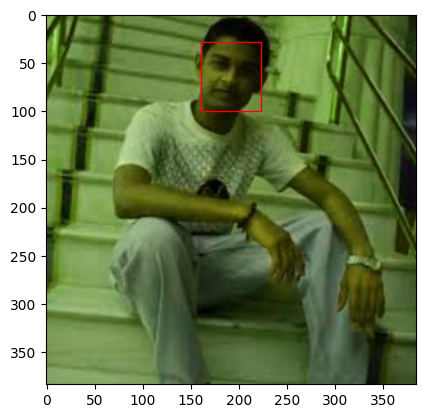

In [16]:
# Define paths and parameters
train_csv = 'dataset/train.csv'
images_dir = 'dataset/utk_train/train'


# Create the dataset
train_dataset, num_age_groups = create_tf_dataset(train_csv, images_dir, batch_size, augment= True)

# Example usage (iterating over the dataset)
for batch in train_dataset:
    images, y_true = batch
    bounding_boxes, genders, ages = y_true

    # Extract the first image and its corresponding bounding boxes
    for i in range(0,5):
        img = images[i].numpy()
        box = bounding_boxes[i].numpy()

        # Plot the first image with bounding boxes
        plot_image_with_boxes(img, box)

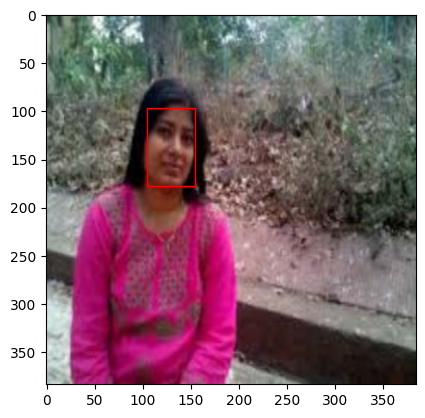

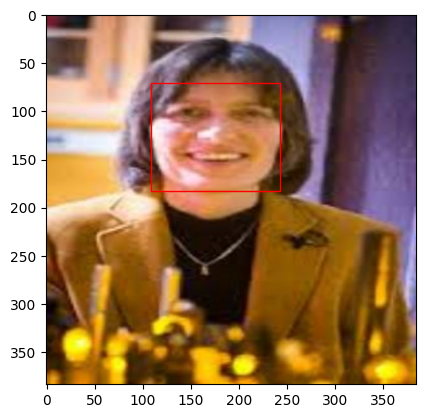

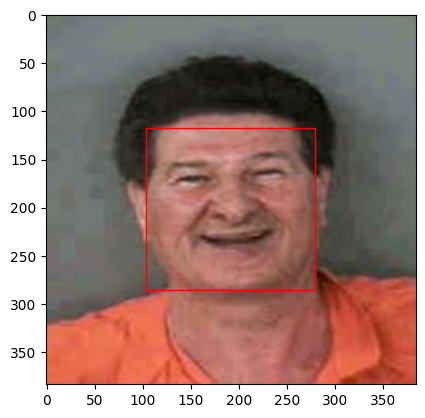

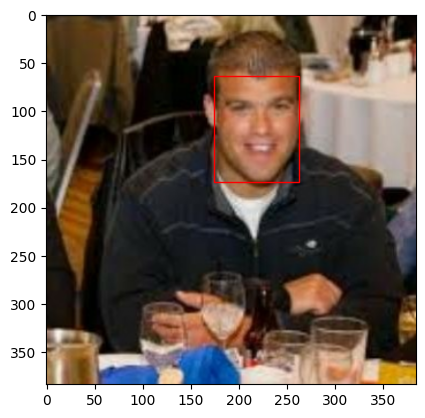

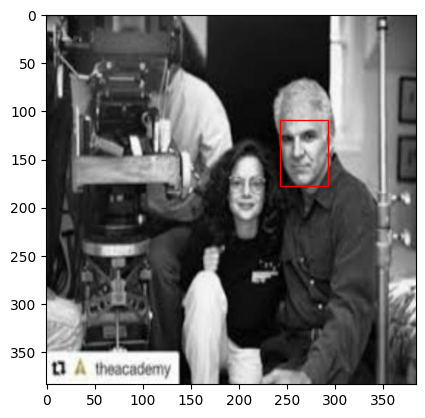

In [17]:
# Define paths and parameters
val_csv = 'dataset/val.csv'
images_dir = 'dataset/utk_val/val'

# Create the dataset
val_dataset, _ = create_tf_dataset(val_csv, images_dir, batch_size, write_json = False)

# Example usage (iterating over the dataset)
for batch in val_dataset:
    images, y_true = batch
    bounding_boxes, genders, ages = y_true

    # Extract the first image and its corresponding bounding boxes
    # first_image = images[0].numpy()
    # first_bounding_boxes = bounding_boxes[0].numpy()
    

    # # Plot the first image with bounding boxes
    # plot_image_with_boxes(first_image, first_bounding_boxes)

    for i in range(0,5):
        img = images[i].numpy()
        box = bounding_boxes[i].numpy()

        # Plot the first image with bounding boxes
        plot_image_with_boxes(img, box)

# FaceVit model 

In [18]:
def mlp(x, hidden_units, dropout_rate, block_name):
    """Simple MLP with dropout"""
    for i in range(len(hidden_units)):
        x = layers.Dense(hidden_units[i], activation=keras.activations.gelu, name= f'Dense_{i}_{block_name}')(x)
        x = layers.Dropout(dropout_rate, name = f'Dropout_{i}_{block_name}')(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, name):
        super().__init__()
        self.patch_size = patch_size
        self.name = name

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size,
                       'name': self.name})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, name):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.name = name

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {   "name": self.name,
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded
    
class Class_Embeddings(layers.Layer):
    def __init__(self, projection_dim, name=None):
        super(Class_Embeddings, self).__init__(name=name)
        self.projection_dim = projection_dim
        self.age_cls_embedding = self.add_weight(
            shape=(1, 1, projection_dim),
            initializer='random_normal',
            trainable=True,
            name='age_cls_embedding'
        )
        self.gender_cls_embedding = self.add_weight(
            shape=(1, 1, projection_dim),
            initializer='random_normal',
            trainable=True,
            name='gender_cls_embedding'
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        age_cls_embedding = tf.tile(self.age_cls_embedding, [batch_size, 1, 1])
        gender_cls_embedding = tf.tile(self.gender_cls_embedding, [batch_size, 1, 1])
        return age_cls_embedding, gender_cls_embedding
    
def build_facevit(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    age_bins_num
):
    inputs = keras.Input(shape=input_shape, name = 'Input')

    # Create patches
    patches = Patches(patch_size, name = 'Patch_creator')(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim, name ='Patch_encoder')(patches)

    # Create the class tokens for the classification tasks
    class_tokens = Class_Embeddings(projection_dim, name='Class_Encoder')
    age_cls_embedding, gender_cls_embedding = class_tokens(inputs)

    # Pre-pend the tokens to the encoded_patches (age then gender)
    encoded_patches = layers.Concatenate(axis=1, name= 'embed_concat')([age_cls_embedding, gender_cls_embedding, encoded_patches])

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6, name = f'LayerNorm_1_block_{i}')(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1, name = f'MultiHeadAttn_block_{i}'
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add(name = f'Skip_1_block_{i}')([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6, name = f'LayerNorm_2_block_{i}')(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1, block_name = f'trans_block_{i}')
        # Skip connection 2.
        encoded_patches = layers.Add(name = f'Skip_2_block_{i}')([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6, name ='LayerNorm_transformed')(encoded_patches)
    representation = layers.Flatten(name = 'Flatten_transformed')(representation[:, 2:, :])
    representation = layers.Dropout(0.3, name = 'Dropout_transformed')(representation)

    # Get the transformed class/age tokens for the classifation tasks
    age_token = encoded_patches[:, 0, :]   
    gender_token = encoded_patches[:, 1, :]

    # Add MLP.
    features_box = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3, block_name= 'MLP_box_out')
    features_age = mlp(age_token, hidden_units=mlp_head_units, dropout_rate=0.3, block_name= 'MLP_age_out')
    features_gender = mlp(gender_token, hidden_units=mlp_head_units, dropout_rate=0.3, block_name= 'MLP_gender_out')

    # FaceViT output layers
    face_box = layers.Dense(4, activation = 'sigmoid', name="face")(features_box)
    gender_classifier = layers.Dense(1, activation='sigmoid', name = 'gender')(features_gender)
    age_classifier = layers.Dense(age_bins_num, activation= 'softmax', name= 'age') (features_age)

    return keras.Model(inputs=inputs, outputs=[face_box, gender_classifier, age_classifier], name = 'FaceVit')

In [11]:
model = build_facevit(input_shape,
                      patch_size,
                      num_patches,
                      projection_dim,
                      num_heads,
                      transformer_units,
                      transformer_layers,
                      mlp_head_units,
                      num_age_groups
                    )
model.summary()

Model: "FaceVit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 384, 384,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Patch_creator       │ (None, 144, 3072) │          0 │ Input[0][0]       │
│ (Patches)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Class_Encoder       │ [(None, 1, 64),   │        128 │ Input[0][0]       │
│ (Class_Embeddings)  │ (None, 1, 64)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Patch_encoder       │ (None, 144, 64)   │    205,888 │ Patch_creator[0]… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_concat        │ (None, 146, 64)   │          0 │ Class_Encoder[0]… │
│ (Concatenate)       │                   │            │ Class_Encoder[0]… │
│                     │                   │            │ Patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerNorm_1_block_0 │ (None, 146, 64)   │        128 │ embed_concat[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MultiHeadAttn_bloc… │ (None, 146, 64)   │     66,368 │ LayerNorm_1_bloc… │
│ (MultiHeadAttentio… │                   │            │ LayerNorm_1_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_1_block_0      │ (None, 146, 64)   │          0 │ MultiHeadAttn_bl… │
│ (Add)               │                   │            │ embed_concat[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerNorm_2_block_0 │ (None, 146, 64)   │        128 │ Skip_1_block_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_0_trans_bloc… │ (None, 146, 128)  │      8,320 │ LayerNorm_2_bloc… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_0_trans_bl… │ (None, 146, 128)  │          0 │ Dense_0_trans_bl… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1_trans_bloc… │ (None, 146, 64)   │      8,256 │ Dropout_0_trans_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1_trans_bl… │ (None, 146, 64)   │          0 │ Dense_1_trans_bl… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_2_block_0      │ (None, 146, 64)   │          0 │ Dropout_1_trans_… │
│ (Add)               │                   │            │ Skip_1_block_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LayerNorm_1_block_1 │ (None, 146, 64)   │        128 │ Skip_2_block_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MultiHeadAttn_bloc… │ (None, 146, 64)   │     66,368 │ LayerNorm_1_bloc… │
│ (MultiHeadAttentio… │                   │            │ LayerNorm_1_bloc… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 27,655,726 (105.50 MB)

 Trainable params: 27,655,726 (105.50 MB)

 Non-trainable params: 0 (0.00 B)

# Test patches layer

Image size: 384 X 384
Patch size: 32 X 32
144 patches per image 
3072 elements per patch


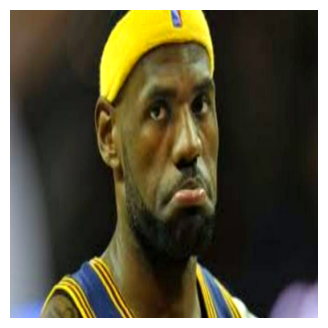

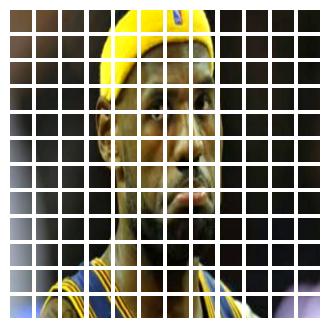

In [12]:
batch = next(iter(train_dataset))
images, _ = batch
image = images[0] * 255
image = image.numpy()

plt.figure(figsize=(4, 4))
plt.imshow(image.astype("uint8"))
plt.axis("off")

patches = Patches(patch_size, name= 'Patches')(np.expand_dims(image, axis=0))
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

# Training function

In [13]:
def run_experiment(model, 
                   train_ds, 
                   validation_ds, 
                   learning_rate, 
                   weight_decay,
                   batch_size, 
                   num_epochs,
                   loss_func,
                   metrics):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model = model_compiler(model, optimizer, loss= loss_func, metrics= metrics)

    checkpoint_filepath = "checkpoints/facevit.weights.h5"

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=validation_ds,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ]
    )

    return history

# Train model
history = run_experiment(
    model,
    train_dataset,
    val_dataset,
    learning_rate, 
    weight_decay, 
    batch_size, 
    num_epochs,
    facevit_losses,
    facevit_metrics
)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 19s/step - age_loss: 0.6408 - age_top_3_accuracy: 0.3379 - face_loss: 0.4088 - face_mse: 0.1380 - gender_accuracy: 0.4832 - gender_loss: 0.2502 - loss: 1.2999 - val_age_loss: 0.5326 - val_age_top_3_accuracy: 0.2480 - val_face_loss: 0.3508 - val_face_mse: 0.3558 - val_gender_accuracy: 0.4766 - val_gender_loss: 0.2554 - val_loss: 1.1387
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 130s 25s/step - age_loss: 0.5509 - age_top_3_accuracy: 0.2824 - face_loss: 0.4166 - face_mse: 0.3186 - gender_accuracy: 0.4827 - gender_loss: 0.2561 - loss: 1.2237 - val_age_loss: 0.5008 - val_age_top_3_accuracy: 0.2266 - val_face_loss: 0.3507 - val_face_mse: 0.3562 - val_gender_accuracy: 0.4766 - val_gender_loss: 0.2511 - val_loss: 1.1026
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 17s/step - age_loss: 0.5201 - age_top_3_accuracy: 0.3212 - face_loss: 0.4050 - face_mse: 0.3418 - gender_accuracy: 0.5036 - gender_loss: 0.2518 - loss: 1.1769 - val_age_loss: 0.4120 - val_age_top_3_accurac

In [ ]:
 # Save the model as a .h5 file
model_save_path = "checkpoints/facevit_model.h5"
model.save(model_save_path)

# Accurancy

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

def create_metrics_table(history, epochs):
    # Assuming history.history is a dictionary
    top_3_age_accuracy = np.max(history.history['val_age_top_3_accuracy']) * 100
    face_mse = np.min(history.history['val_face_mse'])
    gender_accuracy = np.max(history.history['val_gender_accuracy']) * 100

    # Create the table data
    table_data = {
        'Metric Name': [
            'Top-3 Age Accuracy', 
            'Face Bounding Box MSE', 
            'Gender Accuracy'
        ],
        'Value': [
            f"{top_3_age_accuracy:.2f} %", 
            f"{face_mse:.4f}", 
            f"{gender_accuracy:.2f} %"
        ],
        'Training Epochs': [epochs] * 3
    }

    # Convert to DataFrame
    metrics_table = pd.DataFrame(table_data)

    # Apply styling to the table
    styled_table = metrics_table.style.set_properties(**{'border': '2px solid black', 'text-align': 'center'})

    # Display the styled table
    print("\033[1mTraining Metrics:\033[0m")
    display(styled_table)

# Example usage:
# Assuming you have the history object and the number of epochs is 43
create_metrics_table(history, epochs=40)


Training Metrics:


,Metric Name,Value,Training Epochs
0,Top-3 Age Accuracy,93.80 %,40
1,Face Bounding Box MSE,0.0098,40
2,Gender Accuracy,91.40 %,40


# Plot loss

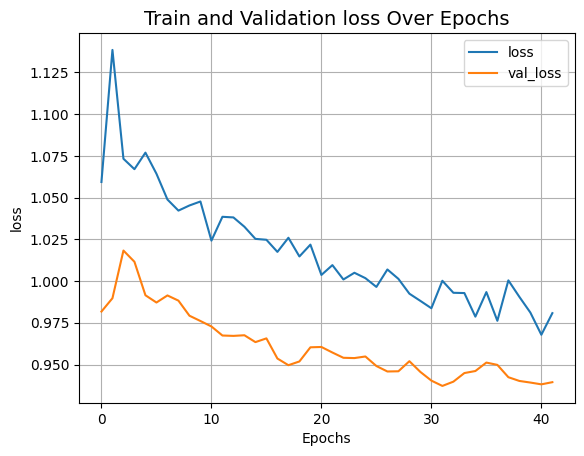

In [19]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_history("loss")

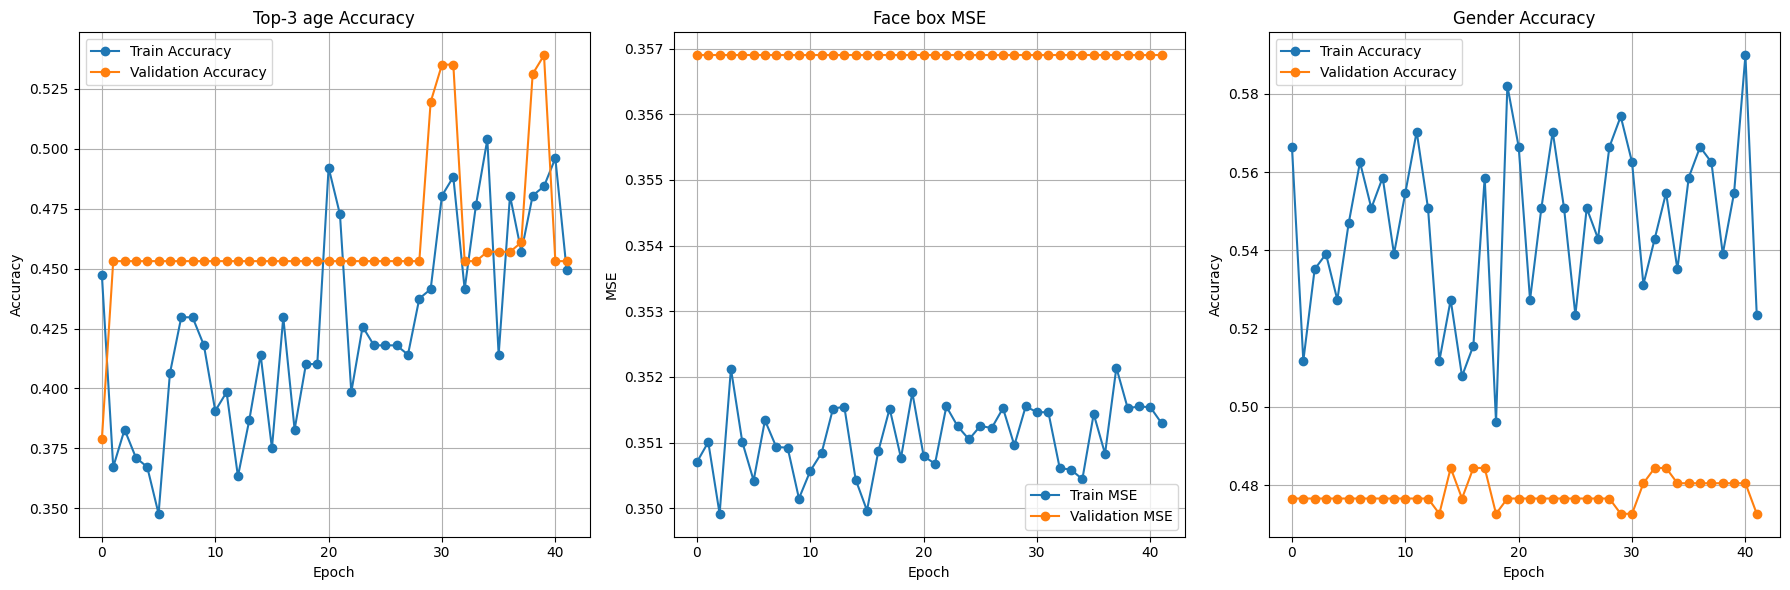

In [20]:
def plot_metrics(history):
    history = history.history
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot age accuracy
    axes[0].plot(history[f'age_top_{age_k}_accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history[f'val_age_top_{age_k}_accuracy'], label='Validation Accuracy', marker='o')
    axes[0].set_title(f'Top-{age_k} age Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot face mse
    axes[1].plot(history['face_mse'], label='Train MSE', marker='o')
    axes[1].plot(history['val_face_mse'], label='Validation MSE', marker='o')
    axes[1].set_title('Face box MSE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MSE')
    axes[1].legend()
    axes[1].grid(True)

    # Plot gender accuracy
    axes[2].plot(history['gender_accuracy'], label='Train Accuracy', marker='o')
    axes[2].plot(history['val_gender_accuracy'], label='Validation Accuracy', marker='o')
    axes[2].set_title('Gender Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(history)

# Test


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


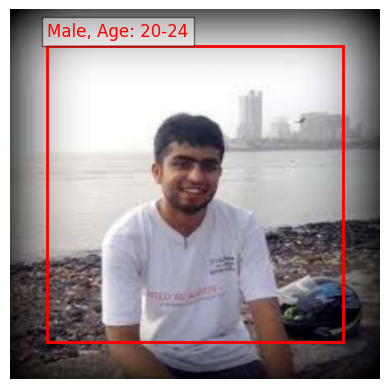

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

# Load the trained model
checkpoint_filepath = "checkpoints/facevit_model.h5"
model = build_facevit(
    input_shape,          # Define the input shape
    patch_size,           # Define the patch size
    num_patches,          # Define the number of patches
    projection_dim,       # Define the projection dimension
    num_heads,            # Define the number of attention heads
    transformer_units,    # Define the transformer units
    transformer_layers,   # Define the number of transformer layers
    mlp_head_units,       # Define the MLP head units
    num_age_groups        # Define the number of age groups
)
model.load_weights(checkpoint_filepath)

def preprocess_image(image_path, target_size=(384, 384)):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

def get_gender_and_age_bin_from_csv(image_path, csv_paths, age_bin_mapping):
    # Extract image name from path
    img_name = image_path.split('/')[-1]

    # Load and merge CSV files
    df_list = [pd.read_csv(csv_path) for csv_path in csv_paths]
    df = pd.concat(df_list, ignore_index=True)

    # Find the row corresponding to the image name
    row = df[df['img_name'] == img_name]

    if not row.empty:
        # Extract gender and age
        gender = row['gender'].values[0]
        age = int(row['age'].values[0])

        # Map gender to 'Male' or 'Female'
        gender_text = 'Male' if gender == 'M' else 'Female'

        # Map age to the corresponding age bin
        age_bin = next((bin for bin, idx in age_bin_mapping.items() if int(bin.split('-')[0]) <= age <= int(bin.split('-')[1])), None)

        return gender_text, age_bin
    else:
        raise ValueError(f"Image name '{img_name}' not found in CSV files.")

# def plot_image_with_predictions(image, bbox, predicted_gender, predicted_age_bin, actual_age_class, age_bin_mapping, image_size=(384, 384, 3)):
#     """Plot image with bounding box, gender, and age predictions."""
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(image)
#     h, w, _ = image_size

#     # Scale bounding box coordinates
#     x1 = int(bbox[0] * w)
#     y1 = int(bbox[1] * h)
#     x2 = int(bbox[2] * w)
#     y2 = int(bbox[3] * h)
#     width = x2 - x1
#     height = y2 - y1

#     # Create a rectangle patch
#     rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

#     # Add text for gender and age
#     predicted_text = f'{predicted_gender}, Predicted Age Bin: {predicted_age_bin}'
#     actual_age_text = f'Actual Age Bin: {list(age_bin_mapping.keys())[actual_age_class]}'
#     plt.text(x1, y1 - 10, predicted_text, color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
#     # plt.text(x1, y1 + height + 20, actual_age_text, color='b', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

#     plt.axis('off')
#     plt.show()

def plot_image_with_predictions(image, bbox, predicted_gender, predicted_age_bin, age_bin_mapping, image_size=(384, 384, 3)):
    """Plot image with bounding box, gender, and age predictions."""
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)
    h, w, _ = image_size

    # Scale bounding box coordinates
    x1 = int(bbox[0] * w)
    y1 = int(bbox[1] * h)
    x2 = int(bbox[2] * w)
    y2 = int(bbox[3] * h)
    width = x2 - x1
    height = y2 - y1

    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Add text for gender and age
    actual_age_text = f'actual Age: {list(age_bin_mapping.keys())[actual_age_class]}'
    predicted_text = f'{predicted_gender}, Age: {predicted_age_bin}'
    plt.text(x1, y1 - 10, predicted_text, color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    # plt.text(x1, y1 + height + 20, color='b', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# Paths
# image_path = 'dataset/utk_train/train/56_1_3_20170119211416888.jpg'
# image_path = 'dataset/utk_train/train/21_0_0_20170116215656696.jpg'  # Replace with your image path
# image_path = 'dataset/utk_train/train/56_1_3_20170119211416888.jpg'
# image_path = 'dataset/utk_val/val/40_1_3_20170119165539693.jpg'
# image_path = 'dataset/utk_val/val/21_0_0_20170117141910383.jpg'
# image_path = 'dataset/utk_val/val/34_0_1_20170117141346326.jpg'
# image_path = 'dataset/utk_train/train/36_0_1_20170117163203851.jpg'
# image_path = 'dataset/utk_train/train/56_1_3_20170119211416888.jpg'
image_path = 'dataset/utk_val/val/22_0_3_20170119202650701.jpg'

csv_paths = ['dataset/train.csv', 'dataset/val.csv']  # List of your CSV file paths
age_bin_json_path = 'age/age_bins.json'  # Replace with your age bins JSON file path

# Load age bin mapping from JSON file
with open(age_bin_json_path) as f:
    age_bin_mapping = json.load(f)

# Preprocess the image
input_image = preprocess_image(image_path)

# Get the predicted gender and age bin from the merged CSVs
predicted_gender, predicted_age_bin = get_gender_and_age_bin_from_csv(image_path, csv_paths, age_bin_mapping)

# Make predictions using the trained model
face_box, gender_pred, age_pred = model.predict(input_image)

# Decode predictions
# face_box = face_box[0]  # Remove batch dimension
face_box = [0.1, 0.1, 0.9, 0.9]
gender_pred = gender_pred[0]
age_pred = age_pred[0]

# Convert age prediction to age class
actual_age_class = np.argmax(age_pred)

# Map actual gender
actual_gender = 'Female' if gender_pred > 0.5 else 'Male'

# Convert predictions to numpy arrays
input_image_np = input_image[0].numpy() * 255  # Remove batch dimension and scale back to original range
input_image_np = input_image_np.astype("uint8")

# Visualize the results
plot_image_with_predictions(input_image_np, face_box, predicted_gender, predicted_age_bin, age_bin_mapping)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


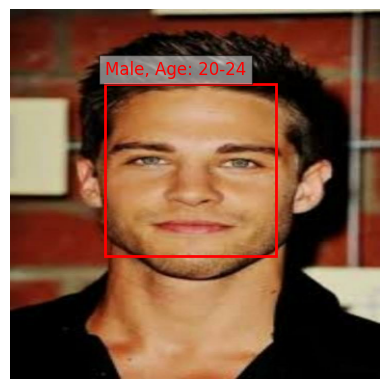

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

# Load the trained model
checkpoint_filepath = "checkpoints/facevit_model.h5"
model = build_facevit(
    input_shape,          # Define the input shape
    patch_size,           # Define the patch size
    num_patches,          # Define the number of patches
    projection_dim,       # Define the projection dimension
    num_heads,            # Define the number of attention heads
    transformer_units,    # Define the transformer units
    transformer_layers,   # Define the number of transformer layers
    mlp_head_units,       # Define the MLP head units
    num_age_groups        # Define the number of age groups
)
model.load_weights(checkpoint_filepath)

def preprocess_image(image_path, target_size=(384, 384)):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

def get_gender_and_age_bin_from_csv(image_path, csv_paths, age_bin_mapping):
    # Extract image name from path
    img_name = image_path.split('/')[-1]

    # Load and merge CSV files
    df_list = [pd.read_csv(csv_path) for csv_path in csv_paths]
    df = pd.concat(df_list, ignore_index=True)

    # Find the row corresponding to the image name
    row = df[df['img_name'] == img_name]

    if not row.empty:
        # Extract gender and age
        gender = row['gender'].values[0]
        age = int(row['age'].values[0])

        # Map gender to 'Male' or 'Female'
        gender_text = 'Male' if gender == 'M' else 'Female'

        # Map age to the corresponding age bin
        age_bin = next((bin for bin, idx in age_bin_mapping.items() if int(bin.split('-')[0]) <= age <= int(bin.split('-')[1])), None)

        return gender_text, age_bin
    else:
        raise ValueError(f"Image name '{img_name}' not found in CSV files.")

# def plot_image_with_predictions(image, bbox, predicted_gender, predicted_age_bin, actual_age_class, age_bin_mapping, image_size=(384, 384, 3)):
#     """Plot image with bounding box, gender, and age predictions."""
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(image)
#     h, w, _ = image_size

#     # Scale bounding box coordinates
#     x1 = int(bbox[0] * w)
#     y1 = int(bbox[1] * h)
#     x2 = int(bbox[2] * w)
#     y2 = int(bbox[3] * h)
#     width = x2 - x1
#     height = y2 - y1

#     # Create a rectangle patch
#     rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

#     # Add text for gender and age
#     predicted_text = f'{predicted_gender}, Predicted Age Bin: {predicted_age_bin}'
#     actual_age_text = f'Actual Age Bin: {list(age_bin_mapping.keys())[actual_age_class]}'
#     plt.text(x1, y1 - 10, predicted_text, color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
#     # plt.text(x1, y1 + height + 20, actual_age_text, color='b', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

#     plt.axis('off')
#     plt.show()

def plot_image_with_predictions(image, bbox, predicted_gender, predicted_age_bin, age_bin_mapping, image_size=(384, 384, 3)):
    """Plot image with bounding box, gender, and age predictions."""
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)
    h, w, _ = image_size

    # Scale bounding box coordinates
    x1 = int(bbox[0] * w)
    y1 = int(bbox[1] * h)
    x2 = int(bbox[2] * w)
    y2 = int(bbox[3] * h)
    width = x2 - x1
    height = y2 - y1

    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Add text for gender and age
    actual_age_text = f'actual Age: {list(age_bin_mapping.keys())[actual_age_class]}'
    predicted_text = f'{predicted_gender}, Age: {predicted_age_bin}'
    plt.text(x1, y1 - 10, predicted_text, color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    # plt.text(x1, y1 + height + 20, color='b', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# Paths
# image_path = 'dataset/utk_train/train/56_1_3_20170119211416888.jpg'
# image_path = 'dataset/utk_train/train/21_0_0_20170116215656696.jpg'  # Replace with your image path
# image_path = 'dataset/utk_train/train/56_1_3_20170119211416888.jpg'
# image_path = 'dataset/utk_val/val/40_1_3_20170119165539693.jpg'
image_path = 'dataset/utk_val/val/21_0_0_20170117141910383.jpg'
# image_path = 'dataset/utk_val/val/34_0_1_20170117141346326.jpg'
# image_path = 'dataset/utk_train/train/36_0_1_20170117163203851.jpg'
# image_path = 'dataset/utk_train/train/56_1_3_20170119211416888.jpg'
# image_path = 'dataset/utk_val/val/22_0_3_20170119202650701.jpg'

csv_paths = ['dataset/train.csv', 'dataset/val.csv']  # List of your CSV file paths
age_bin_json_path = 'age/age_bins.json'  # Replace with your age bins JSON file path

# Load age bin mapping from JSON file
with open(age_bin_json_path) as f:
    age_bin_mapping = json.load(f)

# Preprocess the image
input_image = preprocess_image(image_path)

# Get the predicted gender and age bin from the merged CSVs
predicted_gender, predicted_age_bin = get_gender_and_age_bin_from_csv(image_path, csv_paths, age_bin_mapping)

# Make predictions using the trained model
face_box, gender_pred, age_pred = model.predict(input_image)

# Decode predictions
face_box = face_box[0]  # Remove batch dimension
# face_box = [0.1, 0.1, 0.9, 0.9]
gender_pred = gender_pred[0]
age_pred = age_pred[0]

# Convert age prediction to age class
actual_age_class = np.argmax(age_pred)

# Map actual gender
actual_gender = 'Female' if gender_pred > 0.5 else 'Male'

# Convert predictions to numpy arrays
input_image_np = input_image[0].numpy() * 255  # Remove batch dimension and scale back to original range
input_image_np = input_image_np.astype("uint8")

# Visualize the results
plot_image_with_predictions(input_image_np, face_box, predicted_gender, predicted_age_bin, age_bin_mapping)
